In [2]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
graph = tf.compat.v1.get_default_graph()
loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

NameError: name 'labels' is not defined

# Loading

In [3]:
# Define paths
train_data_dir = 'dogvscat/train'
test_data_dir = 'dogvscat/test'

# Define image preprocessing parameters
img_width, img_height = 100, 100 
batch_size = 32
num_epochs = 20  

# Use ImageDataGenerator to load and preprocess images for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,  # Example rotation range
    width_shift_range=0.2,  # Example width shift range
    height_shift_range=0.2,  # Example height shift range
    fill_mode='nearest'
)

# Only rescale the testing images (no augmentation for testing)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generate batches of image data from the directories for training and testing
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')  # Use 'categorical' for multiclass classification

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 500 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


# Preprocessing data

In [4]:
# Convert generators to numpy arrays
X_train, Y_train = train_generator.next()
X_test, Y_test = test_generator.next()

# Reshape and normalize the data
X_train = X_train.reshape(len(X_train), img_width, img_height, 3) / 255.0
X_test = X_test.reshape(len(X_test), img_width, img_height, 3) / 255.0
Y_train = np.argmax(Y_train, axis=1).reshape(len(Y_train), 1)  # Assuming it's one-hot encoded
Y_test = np.argmax(Y_test, axis=1).reshape(len(Y_test), 1)  # Assuming it's one-hot encoded

# Build the cnn model

In [5]:
num_classes = len(train_generator.class_indices)

# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to feed into dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)     

# Training Data

Epoch 1/20

16/16 [==============================] - 49s 3s/step - loss: 0.6282 - accuracy: 0.6360 - val_loss: 0.4509 - val_accuracy: 0.8200
Epoch 2/20
16/16 [==============================] - 40s 2s/step - loss: 0.5028 - accuracy: 0.7480 - val_loss: 0.4300 - val_accuracy: 0.7800
Epoch 3/20
16/16 [==============================] - 37s 2s/step - loss: 0.4953 - accuracy: 0.7540 - val_loss: 0.3786 - val_accuracy: 0.8400
Epoch 4/20
16/16 [==============================] - 34s 2s/step - loss: 0.4437 - accuracy: 0.7740 - val_loss: 0.3447 - val_accuracy: 0.8200
Epoch 5/20
16/16 [==============================] - 34s 2s/step - loss: 0.4077 - accuracy: 0.8340 - val_loss: 0.3487 - val_accuracy: 0.8400
Epoch 6/20
16/16 [==============================] - 37s 2s/step - loss: 0.3713 - accuracy: 0.8460 - val_loss: 0.3813 - val_accuracy: 0.8200
Epoch 7/20
16/16 [==============================] - 36s 2s/step - loss: 0.3842 - accuracy: 0.8380 - val_loss: 0.3609 - val_accuracy: 0.8400
Epoch 8/20
16/16 [=

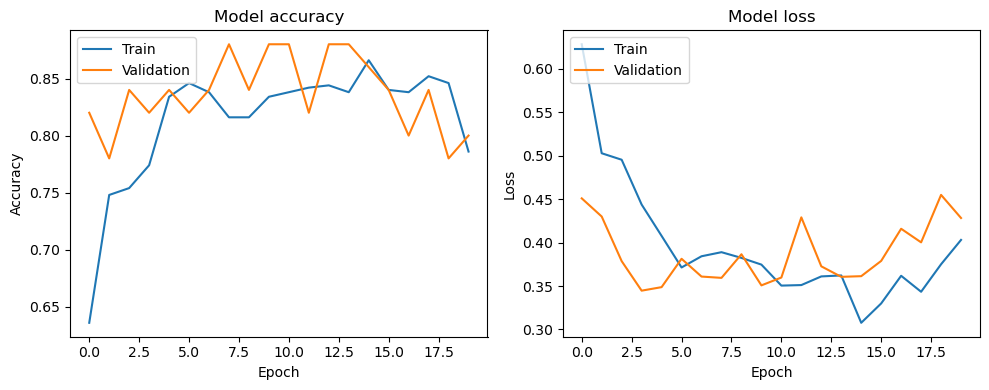

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=num_epochs, validation_data=test_generator, validation_steps=len(test_generator))


# Plot training history
plt.figure(figsize=(10, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model on test data

In [65]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_accuracy}")

2/2 [==============================] - 4s 927ms/step - loss: 0.4386 - accuracy: 0.8200
Test accuracy: 0.8199999928474426


# Select a random image from the test set for prediction

In [1]:
import random

# Get a random batch of test data (one batch)
test_data_batch, test_labels_batch = test_generator.next()

# Select a random index within the batch
random_index = random.randint(0, len(test_data_batch) - 1)

# Get the random image and label from the batch
random_image = test_data_batch[random_index]
random_label = test_labels_batch[random_index]

# Expand dimensions to match the input shape expected by the model
random_image = np.expand_dims(random_image, axis=0)

# Make a prediction using the trained model
predictions = model.predict(random_image)

# Get the predicted class index with the highest probability
predicted_class_index = np.argmax(predictions)

# Map predicted class index to class label
if predicted_class_index == 0:
    predicted_class = 'Cat'
else:
    predicted_class = 'Dog'

# Map actual class index to class label
actual_class_index = np.argmax(random_label)
if actual_class_index == 0:
    actual_class = 'Cat'
else:
    actual_class = 'Dog'

# Display the random image, its actual label, and the predicted label
plt.imshow(random_image.squeeze())
plt.axis('off')
plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}")
plt.show()


NameError: name 'test_generator' is not defined